In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read the data
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')


In [4]:
# Convert dates
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])


In [5]:
# Create customer level aggregations from transactions
customer_transactions = transactions_df.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TotalValue': ['sum', 'mean'],
    'Quantity': ['sum', 'mean']
}).reset_index()

In [6]:
# Flatten column names
customer_transactions.columns = ['CustomerID', 'total_transactions', 'total_spend', 
                               'avg_transaction_value', 'total_quantity', 'avg_quantity']


In [7]:
# Calculate customer age (in days)
current_date = pd.to_datetime('2025-01-28')
customers_df['customer_age_days'] = (current_date - customers_df['SignupDate']).dt.days


In [8]:
# Merge customer profile with transaction aggregations
final_df = customers_df.merge(customer_transactions, on='CustomerID', how='left')

In [9]:
# Fill NAs for customers with no transactions
final_df = final_df.fillna(0)

In [10]:
# Create features for clustering
features = ['customer_age_days', 'total_transactions', 'total_spend', 
           'avg_transaction_value', 'total_quantity', 'avg_quantity']


In [11]:
# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(final_df[features])

In [12]:
print("Data preparation complete. Shape of feature matrix:", X.shape)

Data preparation complete. Shape of feature matrix: (200, 6)


In [13]:
print("\
Features used for clustering:")
for f in features:
    print("- " + f)

Features used for clustering:
- customer_age_days
- total_transactions
- total_spend
- avg_transaction_value
- total_quantity
- avg_quantity


In [14]:
# Perform clustering using K-Means
k_values = range(2, 11)
db_scores = []
silhouette_scores = []
cluster_results = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    
    # Calculate Davies-Bouldin Index and Silhouette Score
    db_index = davies_bouldin_score(X, labels)
    silhouette_avg = silhouette_score(X, labels)
    
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)
    cluster_results[k] = labels

In [15]:
# Find the best number of clusters based on DB Index
best_k = k_values[np.argmin(db_scores)]

In [16]:
print("Clustering complete.")
print("Best number of clusters based on DB Index:", best_k)

Clustering complete.
Best number of clusters based on DB Index: 9


In [17]:
print("DB Index for best K:", min(db_scores))

DB Index for best K: 1.1377976150720759


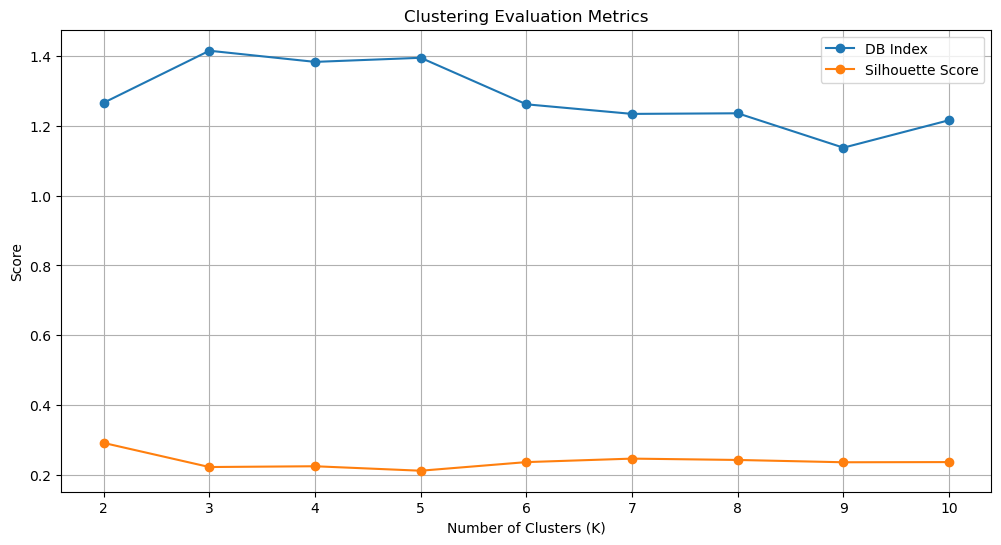

In [18]:
# Plot DB Index and Silhouette Scores
plt.figure(figsize=(12, 6))
plt.plot(k_values, db_scores, marker='o', label='DB Index')
plt.plot(k_values, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Score')
plt.title('Clustering Evaluation Metrics')
plt.legend()
plt.grid()
plt.show()

In [19]:
# Visualize the clusters using the best K
from sklearn.decomposition import PCA

In [20]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [21]:
# Get the labels for the best K
best_labels = cluster_results[best_k]

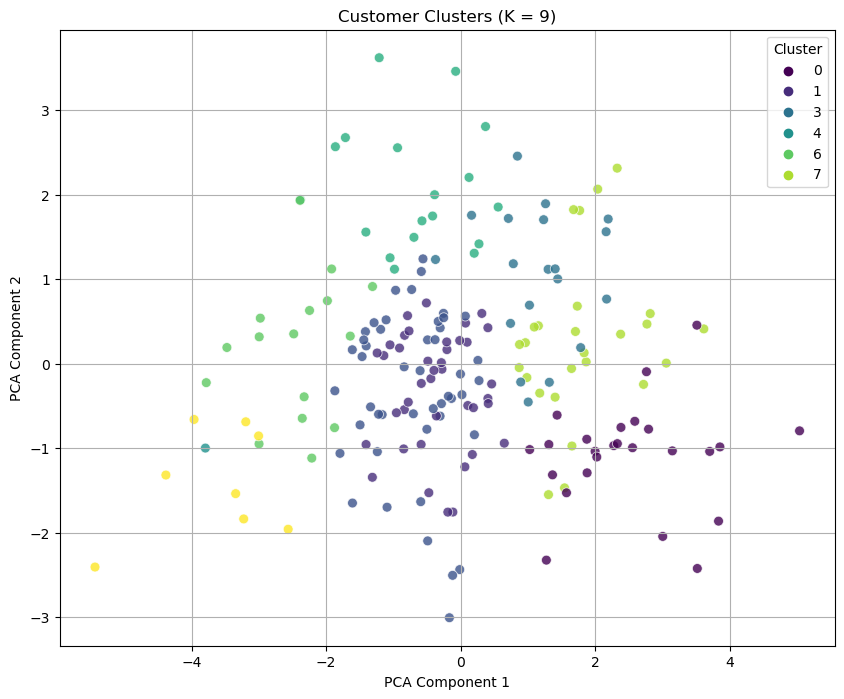

In [22]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=best_labels, palette='viridis', s=50, alpha=0.8)
plt.title('Customer Clusters (K = ' + str(best_k) + ')')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='best')
plt.grid()
plt.show()

In [23]:
# Save the clustering results to a file
final_df['Cluster'] = best_labels
final_df.to_csv('customer_clustering_results.csv', index=False)
print("Cluster visualization complete. Results saved to 'customer_clustering_results.csv'.")

Cluster visualization complete. Results saved to 'customer_clustering_results.csv'.
